# Hate Speech Recognition through Semantic Analysis of Comments

***Analysing comments from Adele's 'Hello' video on YouTube***

## Installations and Imports

In [1]:
# Necessary installations (Run only if needed)
!pip install googletrans
!pip install torch transformers
!pip install nltk
!pip install deep-translator

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 896.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=980d9405f320d3738d8f62e2798e243fbe35a703dc79cf3c20f74a8549437476
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling ch

In [2]:
# Imports
from googleapiclient.discovery import build
from textblob import TextBlob

from googletrans import Translator, LANGUAGES

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import pipeline

from matplotlib import pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.metrics import classification_report

import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from deep_translator import GoogleTranslator

import csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## YouTube API

Run these cells only once if you want to 'extract' comments. Else use the comments that have already been extracted from the pre-processing section.

In [ ]:
 # change the devloper key that corresponds to your google account please. You will have to get an API from google developer console.
youtube = build('youtube', 'v3', developerKey='<your_API_key>')

def fetch_comments(video_id):
    comments = []
    response = youtube.commentThreads().list(part='snippet', videoId=video_id, textFormat='plainText').execute()

    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        # taking first 5000 comments
        if(len(comments) == 5000):
          break

        if 'nextPageToken' in response:
            response = youtube.commentThreads().list(part='snippet', videoId=video_id, textFormat='plainText', pageToken=response['nextPageToken']).execute()
        else:
            break

    return comments

def analyze_sentiment(comments):
    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}

    for comment in comments:
        analysis = TextBlob(comment)  -- see
        if analysis.sentiment.polarity > 0:
            sentiments['positive'] += 1
        elif analysis.sentiment.polarity == 0:
            sentiments['neutral'] += 1
        else:
            sentiments['negative'] += 1

    return sentiments

def translate_english(comments):
  translator = Translator()
  translated_comments = []

  for comment in tqdm(comments):
      if(len(comment)<=5000):
        translated_comment = GoogleTranslator(source='auto', target='en').translate(comment)
        translated_comments.append(translated_comment)

  return translated_comments

video_id = 'YQHsXMglC9A' # "Hello" by Adele Youtube video ID
comments = fetch_comments(video_id)

In [ ]:
comments = translate_english(comments)
#sentiments = analyze_sentiment(comments)
#print(sentiments)

In [ ]:
print(comments)

['im here in 2024 .', 'when i first heard of adele this was my favorite song n still us . love you adele !! 🙏🙏🙏🙏🙏🧡🧡❤️❤️💛💛💚💚💚💙💙💙💜💜🌹🌹🌹🌹🌹', 'Me', "This is how I protested. Triumph , natural bud, good friend's, and a stadium  packed with like minded people rocking to Triumph. PS . Peace", 'I want to bay this youtube I from somali 😮', '2024', '2024', 'like this song happen to me', "I love the song, I've heard it at least 1000 times☺☺☺☺", 'There PAGES ISAAC Fernández', 'ATREYU ISAAC', 'Its meeeee🥰', None, 'Super Star', 'The British are a bunch of $hits. But this Lady can come to the US.', 'A incredible voice with incredible lyrics that anyone can relate to.', 'IM HERE', "*It's been 8 Years, Let's See How Many Legends Still Listening to This Masterpiece!* 🖤", 'Helo is a TOTTENHAM FC fan ADELLE pure quality love it from the other side April 2024', 'Beautiful songs', 'Gg', 'Some of us are on the other side do you realize that', 'Who’s here in 2034?', 'When this came out I was homeless, on drugs

In [ ]:
# Save comments to CSV file
path = "youtube_hello_comments_translated.csv"

with open(path, "w",newline="", encoding="utf-8") as file:
  writer = csv.writer(file)
  writer.writerow(["Comment #", "Comment"])
  for i,comment in enumerate(comments):
    writer.writerow([i,comment])


## Pre-processing comments

Load the csv file for the translated YouTube Comments

In [5]:
path = "/content/youtube_hello_comments_translated.csv"

comments = []

with open(path, "r", encoding="utf-8") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        comment_text = row[1]
        comments.append(comment_text)
print(comments)


['im here in 2024 .', 'when i first heard of adele this was my favorite song n still us . love you adele !! 🙏🙏🙏🙏🙏🧡🧡❤️❤️💛💛💚💚💚💙💙💙💜💜🌹🌹🌹🌹🌹', 'Me', "This is how I protested. Triumph , natural bud, good friend's, and a stadium  packed with like minded people rocking to Triumph. PS . Peace", 'I want to bay this youtube I from somali 😮', '2024', '2024', 'like this song happen to me', "I love the song, I've heard it at least 1000 times☺☺☺☺", 'There PAGES ISAAC Fernández', 'ATREYU ISAAC', 'Its meeeee🥰', '', 'Super Star', 'The British are a bunch of $hits. But this Lady can come to the US.', 'A incredible voice with incredible lyrics that anyone can relate to.', 'IM HERE', "*It's been 8 Years, Let's See How Many Legends Still Listening to This Masterpiece!* 🖤", 'Helo is a TOTTENHAM FC fan ADELLE pure quality love it from the other side April 2024', 'Beautiful songs', 'Gg', 'Some of us are on the other side do you realize that', 'Who’s here in 2034?', 'When this came out I was homeless, on drugs, 

In [7]:
# Function for cleaning comments
def clean_comment(comment):
    # Convert to lowercase
    comment = comment.lower()
    # Remove URLs
    comment = re.sub(r'https?://\S+|www\.\S+', '', comment)
    # Remove user mentions
    comment = re.sub(r'@\w+', '', comment)
    # Remove hashtags (only removing the hash # sign from the word)
    comment = re.sub(r'#', '', comment)
    # Remove HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    # Remove punctuation and special chars
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    comment = re.sub(r'\d+', '', comment)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(comment)
    filtered_words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Re-create the comment from words
    clean_comment = ' '.join(lemmatized_words)
    return clean_comment

## BERT for Sentiment Analysis


### Training
 - RUN ONLY IF starting from translated comments before cleaning i.e.youtube_hello_comments_translated.csv
 - Else skip the next 2 cells

In [ ]:
# Run BERT for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

result = []
scores = []
cleaned_comments = []
sentiment_pipeline = pipeline("sentiment-analysis")

comments = [x for x in comments if x!=None] # Remove any comments that we were unable to translate


for comment in tqdm(comments):
    comment = clean_comment(comment)
    tokens = tokenizer.tokenize(comment)
    if len(tokens) > 512:
        tokens = tokens[:500]
    truncated_comment = tokenizer.convert_tokens_to_string(tokens)
    bert_result = sentiment_pipeline(truncated_comment)
    cleaned_comments.append(truncated_comment)
    result.append(bert_result[0]['label'])
    scores.append(bert_result[0]['score'])

df_senti = pd.DataFrame({'comment':comments, 'cleaned_comment':cleaned_comments, 'sentiment':result, 'score':scores})
df_senti


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

100%|██████████| 4999/4999 [05:24<00:00, 15.38it/s]


,comment,cleaned_comment,sentiment,score
0,im here in 2024 .,im,POSITIVE,0.743037
1,when i first heard of adele this was my favori...,first heard adele favorite song n still u love...,POSITIVE,0.983710
2,Me,,POSITIVE,0.748121
3,"This is how I protested. Triumph , natural bud...",protested triumph natural bud good friend stad...,POSITIVE,0.998206
4,I want to bay this youtube I from somali 😮,want bay youtube somali [UNK],NEGATIVE,0.966648
...,...,...,...,...
4994,2024,,POSITIVE,0.748121
4995,Anyone here in 2030😢😢😢,anyone [UNK],POSITIVE,0.870439
4996,It's not what the song is about but.. I think ...,song think came around time dad died made cry ...,NEGATIVE,0.914363
4997,,,POSITIVE,0.748121


In [ ]:
# Save as csv

df_senti.to_csv('youtube_hello_comments_labeled_scored.csv', index=False)


### Positive vs Negative Sentiments

If starting from labeled_scored data, start run cells from this point.

In [3]:
df_senti=pd.read_csv('/content/youtube_hello_comments_labeled_scored.csv')

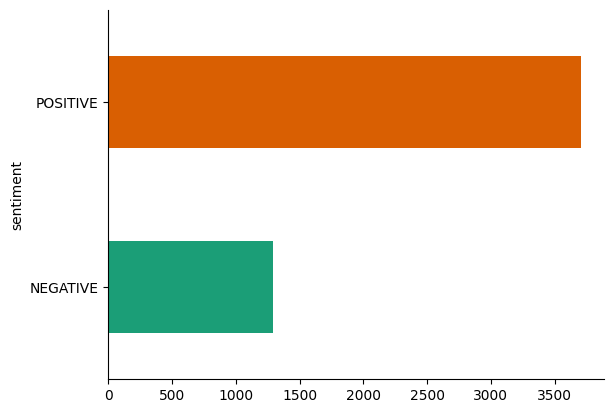

In [4]:
df_senti.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

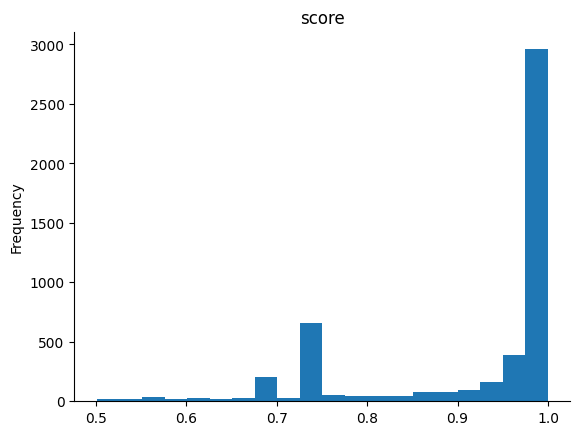

In [5]:
df_senti['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-6-d40d3e133b2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_senti, x='score', y='sentiment', inner='box', palette='Dark2')


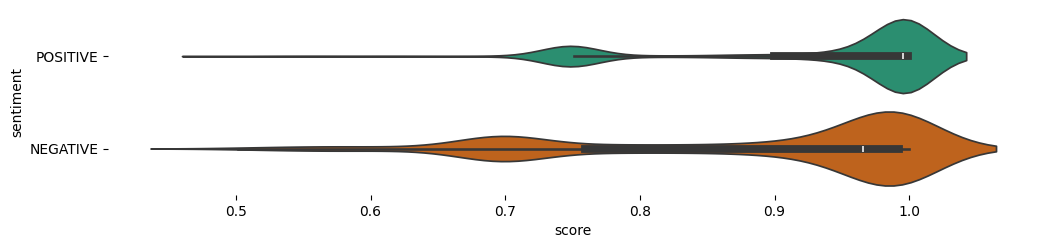

In [6]:
figsize = (12, 1.2 * len(df_senti['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_senti, x='score', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Hate Speech Recognition with Twitter data (labelled)

In [8]:
df = pd.read_csv("labeled_data.csv")
df['label'] = np.where(df['hate_speech'] > 0, 1, 0)
df = df[['tweet','label']]
train_df, val_df = train_test_split(df, test_size=0.1)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = HateSpeechDataset(
    texts=train_df.tweet.to_numpy(),
    labels=train_df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataset = HateSpeechDataset(
    texts=val_df.tweet.to_numpy(),
    labels=val_df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Model Training

Note: SKIP if loading the model directly.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1394/1394 [07:38<00:00,  3.04it/s]


### Model Analysis


In [11]:
# Save model to device after optimization (RUN ONLY IF NOT LOADING MODEL FROM DEVICE DIRECTLY)
torch.save(model.state_dict(), "hate_speech_model.pt")

# Load model from device (RUN ONLY IF LOADING MODEL FROM DEVICE DIRECTLY)
'''model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('hate_speech_model.pt'))
model = model.to(device)'''


"model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)\nmodel.load_state_dict(torch.load('hate_speech_model.pt'))\nmodel = model.to(device)"

In [12]:
def evaluate_model(data_loader, model):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())

    print(classification_report(true_labels, predictions))

evaluate_model(val_data_loader, model)


              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1991
           1       0.66      0.37      0.48       488

    accuracy                           0.84      2479
   macro avg       0.76      0.66      0.69      2479
weighted avg       0.82      0.84      0.82      2479



In [13]:
class CommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


comment_dataset = CommentDataset(
    comments=df_senti['comment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

comment_data_loader = DataLoader(
    comment_dataset,
    batch_size=BATCH_SIZE
)

def get_predictions(model, data_loader):
    model = model.eval()

    comments_texts = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds)
            prediction_probs.extend(outputs.logits)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return predictions, prediction_probs

predictions, prediction_probs = get_predictions(model, comment_data_loader)

df_senti['predicted_label'] = predictions.numpy()


100%|██████████| 313/313 [00:36<00:00,  8.47it/s]


Comments classified as hate speech (predicted label = 1)

In [14]:
df_senti[df_senti['predicted_label']==1]

,comment,cleaned_comment,sentiment,score,predicted_label
105,16 YRS HELLO FROM THE OTHERSIDE JEWS GOVERNMENTS,yr hello otherside jew government,NEGATIVE,0.955505,1
234,its been 8 yeas now...,yea,POSITIVE,0.772059,1
481,Where is the translation into Arabic? Thank yo...,translation arabic thank ’ racist,POSITIVE,0.739850,1
524,Where are the Arabs and Muslims?,arab muslim,POSITIVE,0.886006,1
743,half the world heard this,half world heard,POSITIVE,0.917445,1
879,THEY should remain with others at the camp or ...,remain others camp carry white sign good alive,POSITIVE,0.993015,1
931,Any Brazilians there?😅,brazilian [UNK],POSITIVE,0.927320,1
1208,it's ok to be white,ok white,POSITIVE,0.998833,1
1212,It is precisely for your political opinions th...,precisely political opinion want whole world a...,POSITIVE,0.965624,1
1370,But we must be racist,must racist,NEGATIVE,0.999548,1


Frequency of labels

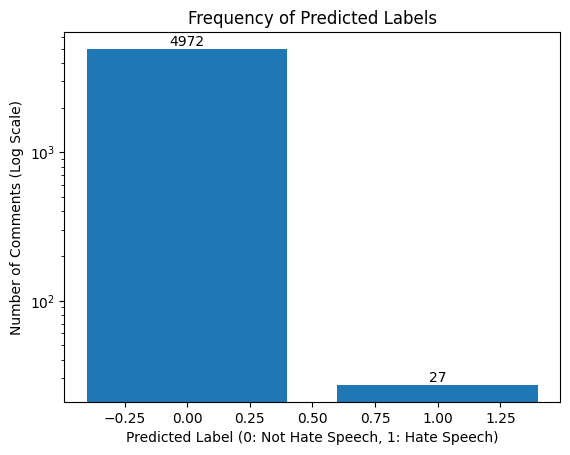

In [15]:
label_counts = df_senti['predicted_label'].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.yscale('log')

for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Frequency of Predicted Labels')
plt.xlabel('Predicted Label (0: Not Hate Speech, 1: Hate Speech)')
plt.ylabel('Number of Comments (Log Scale)')

plt.show()


## Clustering
***An unsupervised approach***

In [16]:
comments = train_df['tweet'].astype(str).tolist()

# Parameters
max_features = 10000
maxlen = 100
embedding_dim = 32

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

x_train = pad_sequences(sequences, maxlen=maxlen)

input_text = Input(shape=(maxlen,))
encoded = Dense(embedding_dim, activation='relu')(input_text)
decoded = Dense(maxlen, activation='sigmoid')(encoded)

autoencoder = Model(input_text, decoded)
encoder = Model(input_text, encoded)

autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True)


Epoch 1/50
88/88 [==============================] - 3s 3ms/step - loss: -179231.1094
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: -1678702.8750
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: -5883994.5000
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: -12767574.0000
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: -22064746.0000
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: -33697340.0000
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: -47494628.0000
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: -63430332.0000
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: -81387312.0000
Epoch 10/50
88/88 [==============================] - 0s 3ms/step - loss: -101294488.0000
Epoch 11/50
88/88 [==============================] - 0s 3ms/step - loss: -123178800.0000
Epoch 12/50
88/88 [========================

In [17]:
comments = df_senti['cleaned_comment'].astype(str).tolist()

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

x_train = pad_sequences(sequences, maxlen=maxlen)
comment_embeddings = encoder.predict(x_train)

157/157 [==============================] - 0s 1ms/step


In [18]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(comment_embeddings)

df_senti['cluster'] = kmeans.labels_
df_senti

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,comment,cleaned_comment,sentiment,score,predicted_label,cluster
0,im here in 2024 .,im,POSITIVE,0.743037,0,0
1,when i first heard of adele this was my favori...,first heard adele favorite song n still u love...,POSITIVE,0.983710,0,0
2,Me,NaN,POSITIVE,0.748121,0,0
3,"This is how I protested. Triumph , natural bud...",protested triumph natural bud good friend stad...,POSITIVE,0.998206,0,1
4,I want to bay this youtube I from somali 😮,want bay youtube somali [UNK],NEGATIVE,0.966648,0,3
...,...,...,...,...,...,...
4994,2024,NaN,POSITIVE,0.748121,0,0
4995,Anyone here in 2030😢😢😢,anyone [UNK],POSITIVE,0.870439,0,0
4996,It's not what the song is about but.. I think ...,song think came around time dad died made cry ...,NEGATIVE,0.914363,0,1
4997,NaN,NaN,POSITIVE,0.748121,0,0


Save or Load clustered data

In [44]:
#df_senti.to_csv('youtube_hello_comments_clustered.csv', index=False)
df_senti=pd.read_csv('/content/youtube_hello_comments_clustered.csv')


Percentage of Predicted Hate Speech within Each Cluster

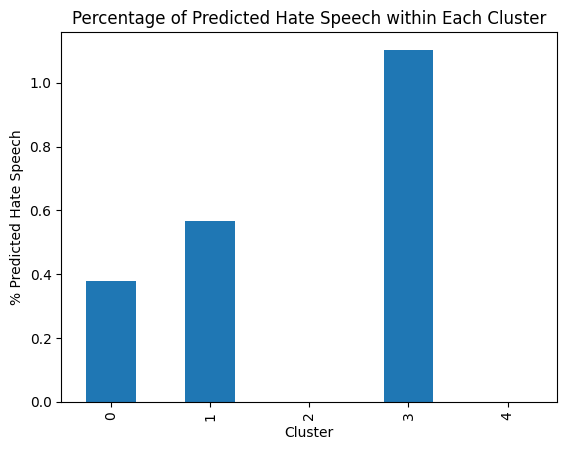

In [19]:
cluster_counts = df_senti.groupby('cluster')['predicted_label'].value_counts().unstack()
cluster_counts['% Hate Speech'] = cluster_counts[1] / (cluster_counts[0] + cluster_counts[1]) * 100

ax = cluster_counts['% Hate Speech'].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('% Predicted Hate Speech')
plt.title('Percentage of Predicted Hate Speech within Each Cluster')
plt.show()

As a % of total hate speech

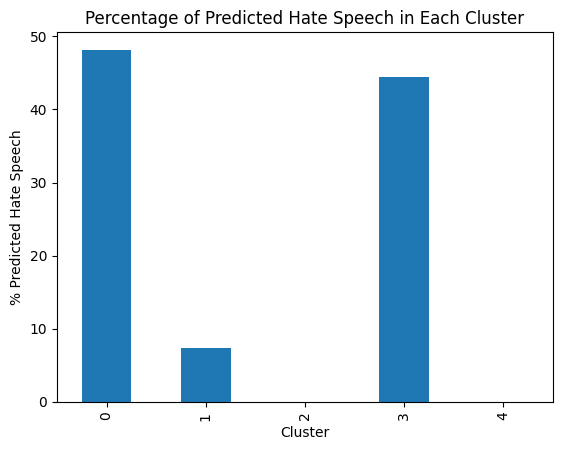

In [20]:
cluster_counts['% Hate Speech'] = cluster_counts[1] / label_counts[1] * 100

ax = cluster_counts['% Hate Speech'].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('% Predicted Hate Speech')
plt.title('Percentage of Predicted Hate Speech in Each Cluster')
plt.show()

Clearly clusters 0 and 3 seem to be associated most with hate-speech.

<ipython-input-21-65b98de3e6eb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_senti, x='cluster', y='sentiment', inner='box', palette='Dark2')


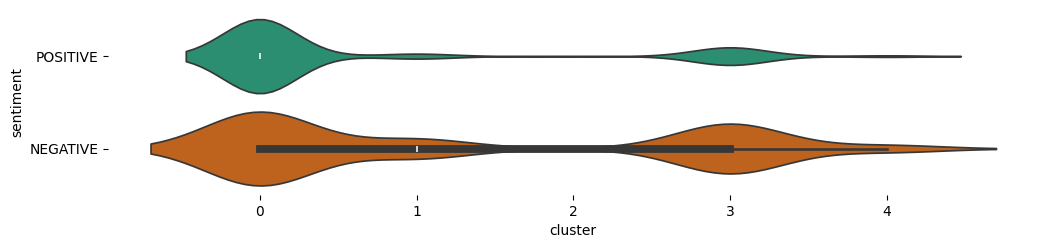

In [21]:
figsize = (12, 1.2 * len(df_senti['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_senti, x='cluster', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [22]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, comment_embeddings)
representative_comments = df_senti['cleaned_comment'].iloc[closest]


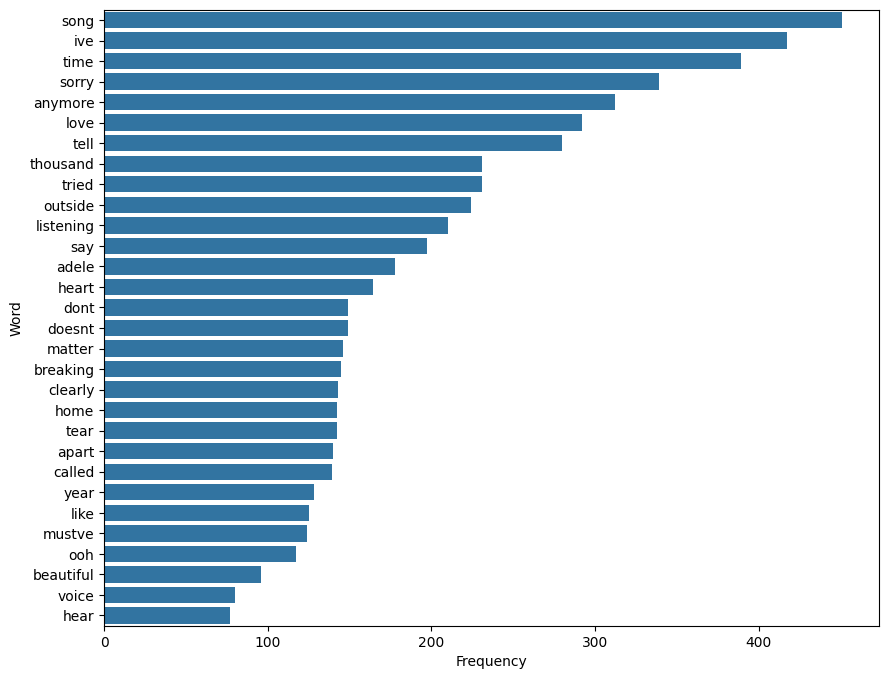

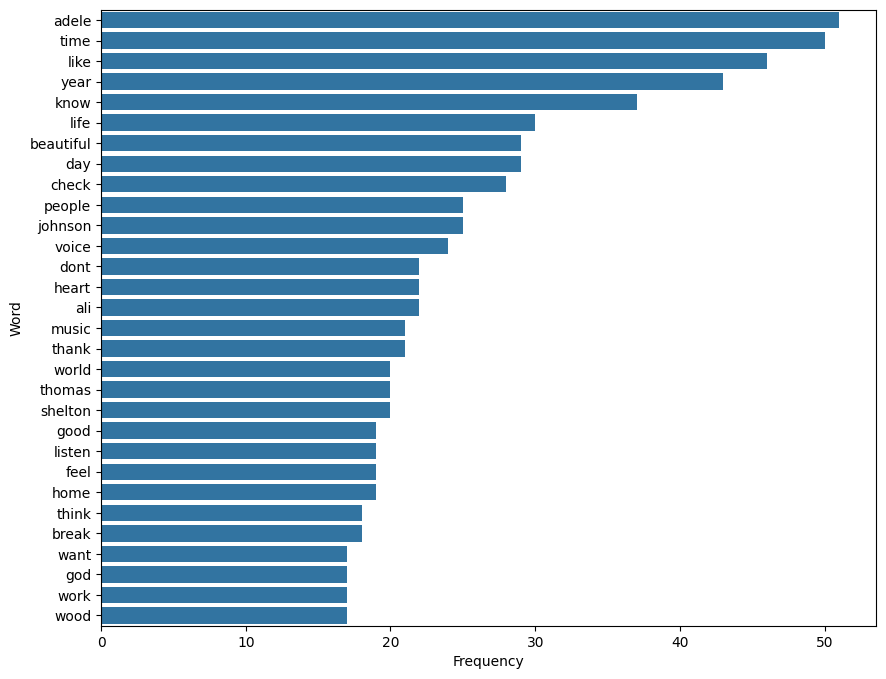

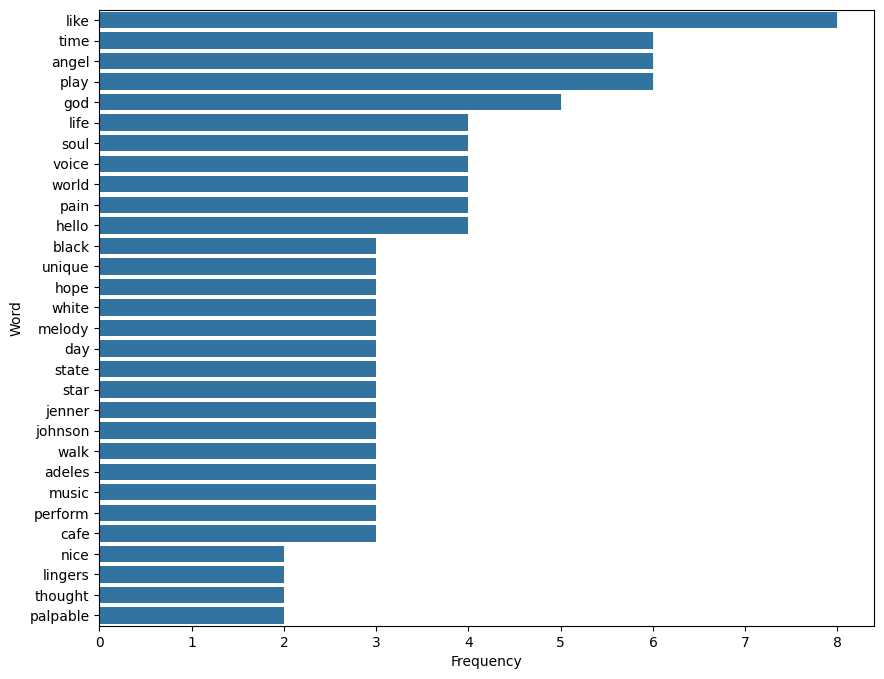

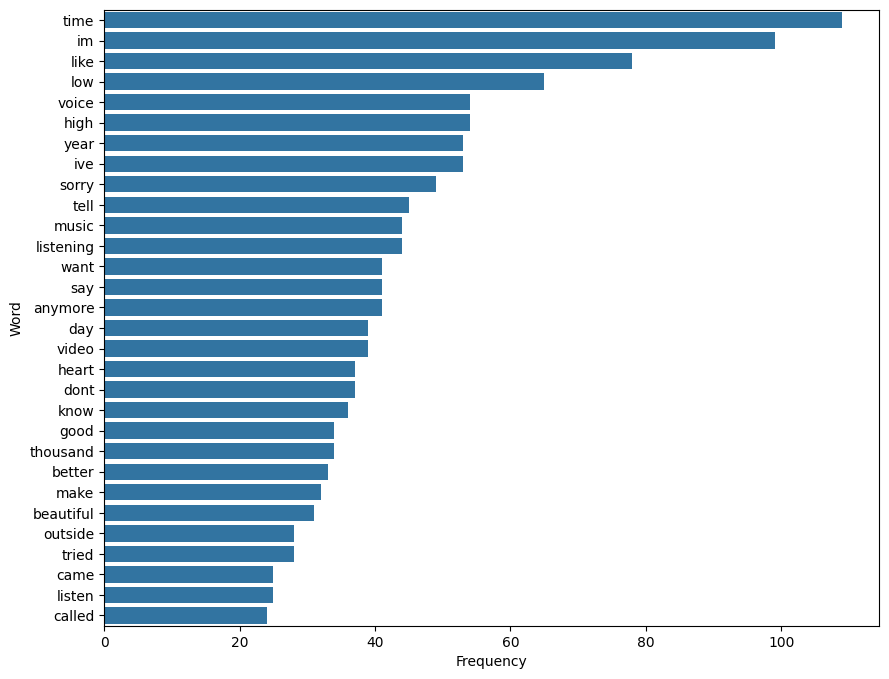

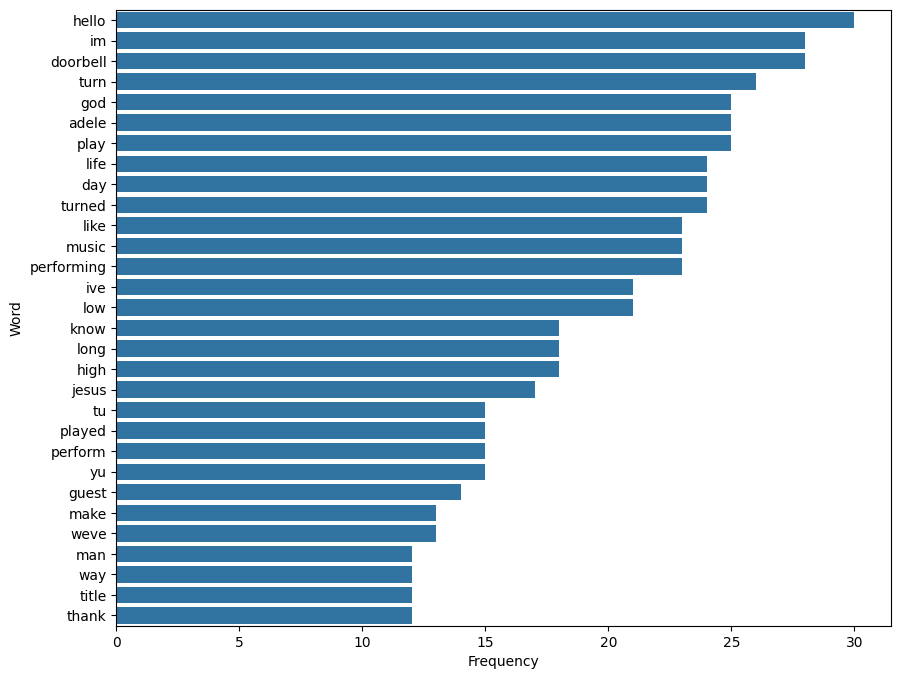

In [40]:
df_senti=df_senti[~pd.isna(df_senti['cleaned_comment'])]
vectorizer = CountVectorizer(stop_words='english')
for i in range(num_clusters):
  #ind = df_senti.iloc[(df_senti['cluster']==i) & (pd.Series.isna(df_senti['cleaned_comment']))]
  all_words = vectorizer.fit_transform(df_senti[df_senti['cluster']==i]['cleaned_comment'])
  sum_words = all_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

  sorted_words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

  plt.figure(figsize=(10, 8))
  ax = sns.barplot(x=[w[1] for w in sorted_words_freq[5:35]], y=[w[0] for w in sorted_words_freq[5:35]])
  # plt.title('Top Words Across Cluster ',i)
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.show()


In [42]:
# Apply LDA topic modeling to each cluster
n_topics = 1
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

for i in range(kmeans.n_clusters):
    cluster_comments = df_senti[df_senti['cluster'] == i]['cleaned_comment']
    cluster_vectorized = vectorizer.transform(cluster_comments)
    lda.fit(cluster_vectorized)

    for idx, topic in enumerate(lda.components_):
        print(f"Cluster {i}, Topic {idx}")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-20:]])


Cluster 0, Topic 0
['doesnt', 'heart', 'adele', 'say', 'listening', 'outside', 'thousand', 'tried', 'tell', 'love', 'anymore', 'sorry', 'time', 'ive', 'song', 'im', 'high', 'low', 'hello', 'unk']
Cluster 1, Topic 0
['thank', 'music', 'heart', 'dont', 'voice', 'people', 'check', 'beautiful', 'day', 'life', 'know', 'year', 'like', 'time', 'adele', 'hello', 'im', 'love', 'song', 'unk']
Cluster 2, Topic 0
['perform', 'music', 'walk', 'adeles', 'world', 'soul', 'life', 'pain', 'hello', 'voice', 'god', 'angel', 'play', 'time', 'like', 'adele', 'song', 'love', 'unk', 'im']
Cluster 3, Topic 0
['anymore', 'want', 'say', 'music', 'listening', 'tell', 'sorry', 'ive', 'year', 'voice', 'high', 'low', 'like', 'im', 'time', 'hello', 'adele', 'love', 'song', 'unk']
Cluster 4, Topic 0
['ive', 'low', 'performing', 'music', 'like', 'turned', 'day', 'life', 'play', 'god', 'adele', 'turn', 'im', 'doorbell', 'hello', 'year', 'love', 'time', 'unk', 'song']
